<a href="https://colab.research.google.com/github/LCaravaggio/ClaseTimeSeries/blob/main/Ejercicio4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
from google.colab import drive
import json

import requests
from requests.auth import HTTPBasicAuth

import pandas as pd

In [133]:
drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/alphacast.json", 'r') as f:
    api_token= json.load(f)

Mounted at /content/drive


In [134]:
# Definir user key para la API
user_key = api_token["key"]

También es posible tomar dos series de un mismo dataset: 

In [135]:
# Merval y GGAL
ds='5816' # Equity Argentina
select1='71484' # GGAL
select2='71486' # Merval
select3='71489' #SUP
equity = requests.get('https://api.alphacast.io/datasets/'+ds+'/data?apiKey='+user_key+'&%24select='+ select1 +'%2C'+ select2 + '%2C'+ select3 + '&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('equity.csv','wb').write(equity.content)
equity = pd.read_csv('equity.csv',delimiter = ',')

In [136]:
equity=equity.dropna()

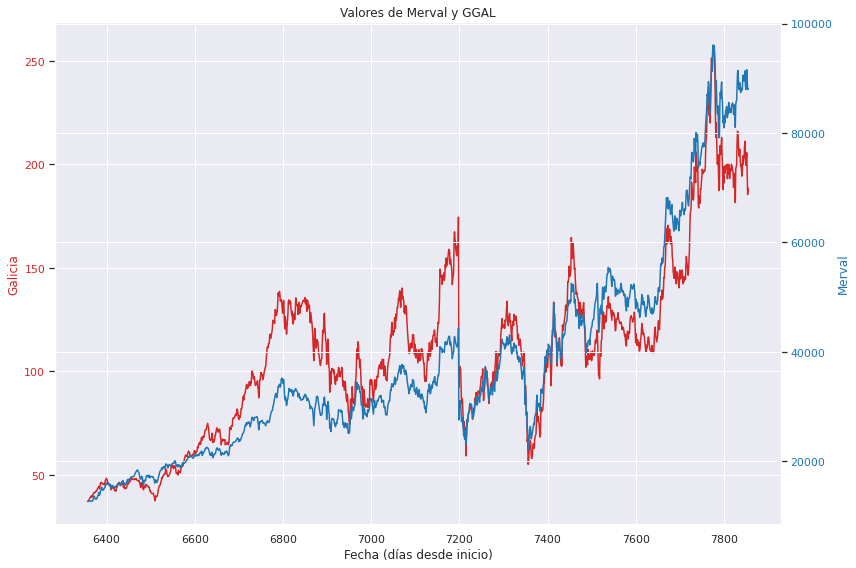

In [137]:
import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt


mpl.rcParams['figure.figsize'] = (12,8)

time = equity.index

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Fecha (días desde inicio)')
ax1.set_ylabel('Galicia', color = color)
ax1.plot(time, equity.GGAL, color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Merval', color = color) 
ax2.plot(time, equity.MERVAL, color = color)
ax2.tick_params(axis = 'y', labelcolor = color)

plt.title('Valores de Merval y GGAL')

fig.tight_layout()  
plt.show()

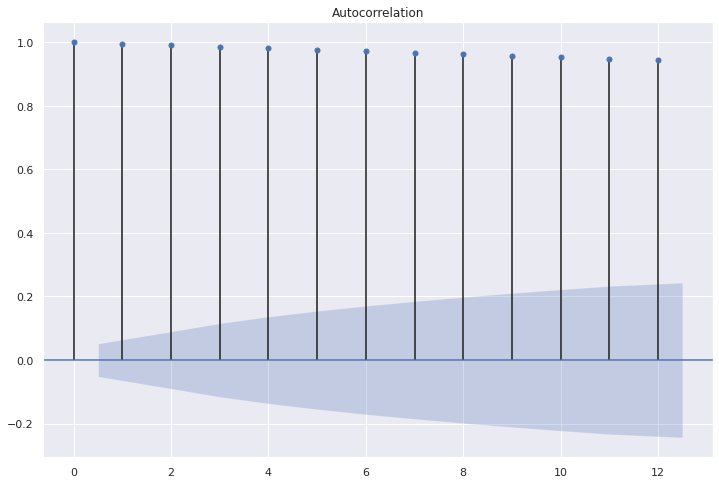

In [138]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Seteamos el tamaño del plot a 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# FAS con 12 lags
plot = plot_acf(equity.MERVAL, lags = 12)

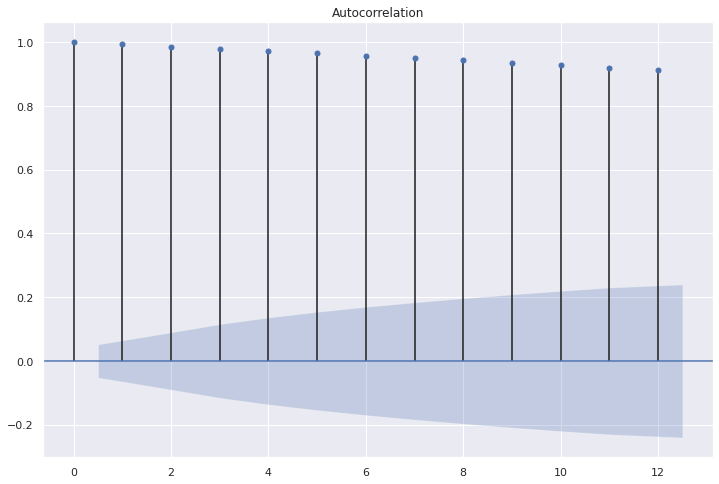

In [139]:
# Seteamos el tamaño del plot a 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# FAS con 12 lags
plot = plot_acf(equity.GGAL, lags = 12)

In [140]:
# importamos el paquete para el test de Dickey-Fuller
from statsmodels.tsa.stattools import adfuller

# Corremos el ADF sin constante, con constante y con constante y tendencia lineal
# GGAL
for i in ['nc', 'c', 'ct']:
    result = adfuller(equity.GGAL, regression = i)
    print('ADF Statistic with %s for GGAL price: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

# Corremos el ADF sin constante, con constante y con constante y tendencia lineal
# MERVAL
for i in ['nc', 'c', 'ct']:
    result = adfuller(equity.MERVAL, regression = i)
    print('ADF Statistic with %s for Merval level: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

ADF Statistic with nc for GGAL price: -0.023235
p-value: 0.676496

ADF Statistic with c for GGAL price: -2.048494
p-value: 0.265723

ADF Statistic with ct for GGAL price: -3.589201
p-value: 0.030771

ADF Statistic with nc for Merval level: 1.566189
p-value: 0.971305

ADF Statistic with c for Merval level: 0.030558
p-value: 0.960987

ADF Statistic with ct for Merval level: -1.892143
p-value: 0.658731



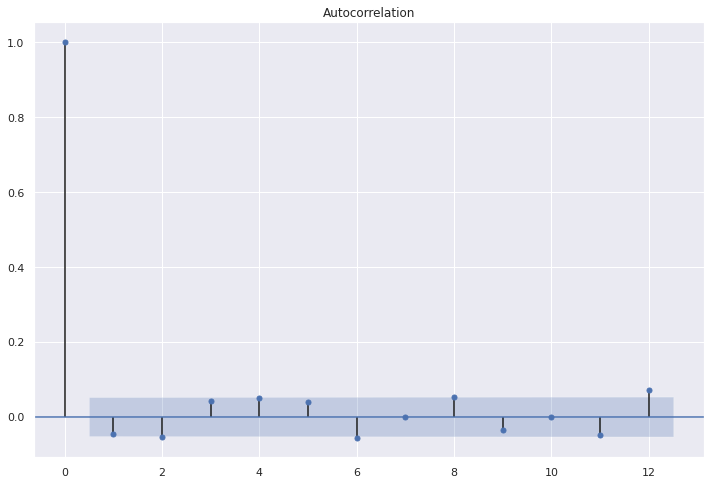

In [141]:
# Hacemos lo mismo que antes, pero sobre la primera diferencia
# GGAL

mpl.rcParams['figure.figsize'] = (12,8)
plot = plot_acf(equity.GGAL.diff().dropna(), lags = 12)

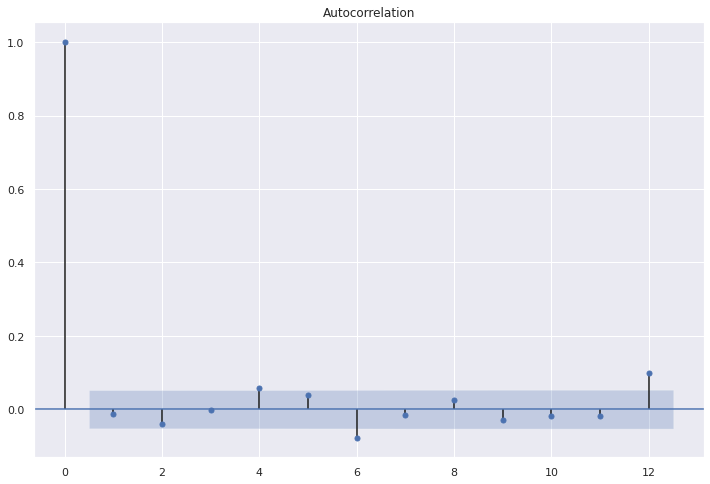

In [142]:
# Hacemos lo mismo que antes, pero sobre la primera diferencia
# Merval

mpl.rcParams['figure.figsize'] = (12,8)
plot = plot_acf(equity.MERVAL.diff().dropna(), lags = 12)

In [143]:
# También corremos los test de Dickey-Fuller
# GGAL
for i in ['nc', 'c', 'ct']:
    result = adfuller(equity.GGAL.diff().dropna(), regression = i)
    print('ADF Statistic with %s for Closing my_stock_train price: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

# performs ADF tests with no constant, a constant, and a constant plus linear trend on differenced
# closing market level
for i in ['nc', 'c', 'ct']:
    result = adfuller(equity.MERVAL.diff().dropna(), regression = i)
    print('ADF Statistic with %s for Closing my_market_train level: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

ADF Statistic with nc for Closing my_stock_train price: -8.529538
p-value: 0.000000

ADF Statistic with c for Closing my_stock_train price: -8.563257
p-value: 0.000000

ADF Statistic with ct for Closing my_stock_train price: -8.559501
p-value: 0.000000

ADF Statistic with nc for Closing my_market_train level: -8.724664
p-value: 0.000000

ADF Statistic with c for Closing my_market_train level: -8.902421
p-value: 0.000000

ADF Statistic with ct for Closing my_market_train level: -8.957696
p-value: 0.000000



Primero corremos el modelo en nivel y chequeamos que los residuos sean estacionarios


In [144]:
# agregamos una tendencia
from statsmodels.tsa.tsatools import add_trend
equity = add_trend(equity, trend='ct')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [145]:
# importamos la librería para correr el modelo
import statsmodels.api as sm

# estimamos la regresión lineal
lr_model = sm.OLS(equity.MERVAL, equity[['trend','GGAL']])
lr_model_fit = lr_model.fit(cov_type='HC0')

# imprimimos los resultados
print(lr_model_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                 MERVAL   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                          2.318e+04
Date:                Thu, 10 Mar 2022   Prob (F-statistic):                        0.00
Time:                        17:46:26   Log-Likelihood:                         -14186.
No. Observations:                1409   AIC:                                  2.838e+04
Df Residuals:                    1407   BIC:                                  2.839e+04
Df Model:                           2                                                  
Covariance Type:                  HC0                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [146]:
for i in ['nc', 'c', 'ct']:
    result = adfuller(lr_model_fit.resid, regression = i)
    print('ADF Statistic with %s para el residuo: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

ADF Statistic with nc para el residuo: 0.135128
p-value: 0.727386

ADF Statistic with c para el residuo: 0.218792
p-value: 0.973296

ADF Statistic with ct para el residuo: -0.149356
p-value: 0.992362



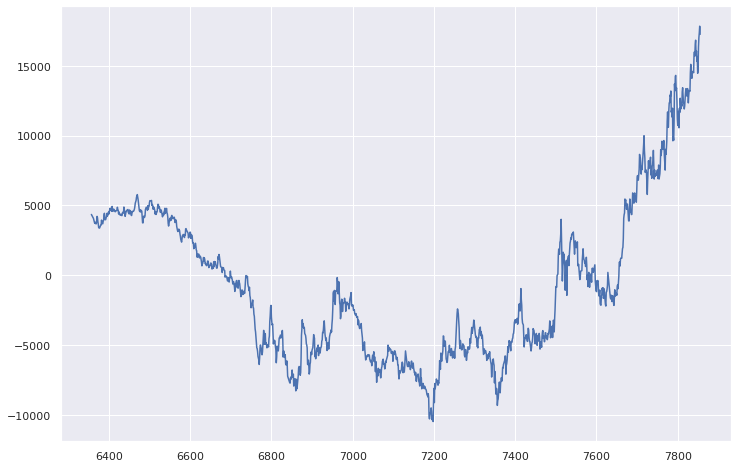

In [147]:
import seaborn as sns

sns.set_theme(style='darkgrid')
def graficar(variable):
    fig = sns.lineplot(x=variable.index, y=variable)
    plt.title(variable.name)
    plt.savefig('%s.png'%variable.name)
    return fig

graficar(lr_model_fit.resid)

In [148]:
# Agergamos 3 meses de rezago para el Merval
for i in range(1, 4):
    new_col = 'MERVAL_l' + str(i)
    equity[new_col] = equity.MERVAL.shift(i)
    
# Agergamos 3 meses de rezago para GGAL
for i in range(1, 4):
    new_col = 'GGAL_l' + str(i)
    equity[new_col] = equity.GGAL.shift(i)

Luego agregamos el regreso de los residuos de la primera regresión como variable explicativa en un nuevo modelo

In [149]:
equity['disequilibrium'] = lr_model_fit.resid
equity.disequilibrium = equity.disequilibrium.shift(1)

equity_copia = equity.copy()


# for i en la lista de columnas que queremos direfenciar...
for i in ['GGAL', 'GGAL_l1', 'GGAL_l2', 'GGAL_l3', 'MERVAL_l1', 'MERVAL_l2', 'MERVAL_l3']:
    # diferencia columna i
    equity_copia[i] = equity_copia[i].diff()

# eliminamos la primera fila porque se pierde al hacer la diferencia
equity_copia= equity_copia.dropna()

# lista de predictores
predictors = ['GGAL_l1', 'GGAL_l2', 'GGAL_l3', 
              'MERVAL_l1', 'MERVAL_l2', 'MERVAL_l3', 
             'disequilibrium', 'const']

# estimamos la regresión lineal de GGAL contra sus rezagos, los rezagos del merval y una correción de error
ecm = sm.OLS(equity_copia.GGAL, equity_copia[predictors])
ecm_fit = ecm.fit(cov_type='HC0')

# imprimimos resultados
print(ecm_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   GGAL   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.183
Date:                Thu, 10 Mar 2022   Prob (F-statistic):              0.309
Time:                        17:46:27   Log-Likelihood:                -4080.5
No. Observations:                1405   AIC:                             8177.
Df Residuals:                    1397   BIC:                             8219.
Df Model:                           7                                         
Covariance Type:                  HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
GGAL_l1           -0.0854      0.084     -1.

# VECM

In [150]:
# importamos la librería para correr el modelo
import statsmodels.api as sm

# estimamos la regresión lineal
lr_model = sm.OLS(equity.MERVAL, equity[['trend','SUPV','GGAL']])
lr_model_fit = lr_model.fit(cov_type='HC0')

# imprimimos los resultados
print(lr_model_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                 MERVAL   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          3.382e+04
Date:                Thu, 10 Mar 2022   Prob (F-statistic):                        0.00
Time:                        17:46:27   Log-Likelihood:                         -14102.
No. Observations:                1409   AIC:                                  2.821e+04
Df Residuals:                    1406   BIC:                                  2.823e+04
Df Model:                           3                                                  
Covariance Type:                  HC0                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [151]:
for i in ['nc', 'c', 'ct']:
    result = adfuller(lr_model_fit.resid, regression = i)
    print('ADF Statistic with %s para el residuo: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

ADF Statistic with nc para el residuo: -0.826414
p-value: 0.359449

ADF Statistic with c para el residuo: -0.812842
p-value: 0.815321

ADF Statistic with ct para el residuo: -0.840663
p-value: 0.962082



In [154]:
# Agergamos 3 meses de rezago para SUPV
for i in range(1, 4):
    new_col = 'SUPV_l' + str(i)
    equity_copia[new_col] =equity_copia.SUPV.shift(i)

In [155]:
# for i en la lista de columnas que queremos direfenciar...
for i in ['SUPV_l1', 'SUPV_l2', 'SUPV_l3']:
    # diferencia columna i
    equity_copia[i] = equity_copia[i].diff()

# eliminamos la primera fila porque se pierde al hacer la diferencia
equity_copia= equity_copia.dropna()

# lista de predictores
predictors = ['GGAL_l1', 'GGAL_l2', 'GGAL_l3', 
              'MERVAL_l1', 'MERVAL_l2', 'MERVAL_l3', 
              'SUPV_l1', 'SUPV_l2', 'SUPV_l3', 
             'disequilibrium', 'const']

# estimamos la regresión lineal de GGAL contra sus rezagos, los rezagos del merval, SUPV y una correción de error
ecm = sm.OLS(equity_copia.GGAL, equity_copia[predictors])
ecm_fit = ecm.fit(cov_type='HC0')

# imprimimos resultados
print(ecm_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   GGAL   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.122
Date:                Thu, 10 Mar 2022   Prob (F-statistic):              0.342
Time:                        17:47:10   Log-Likelihood:                -4067.4
No. Observations:                1401   AIC:                             8157.
Df Residuals:                    1390   BIC:                             8214.
Df Model:                          10                                         
Covariance Type:                  HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
GGAL_l1           -0.1539      0.100     -1.